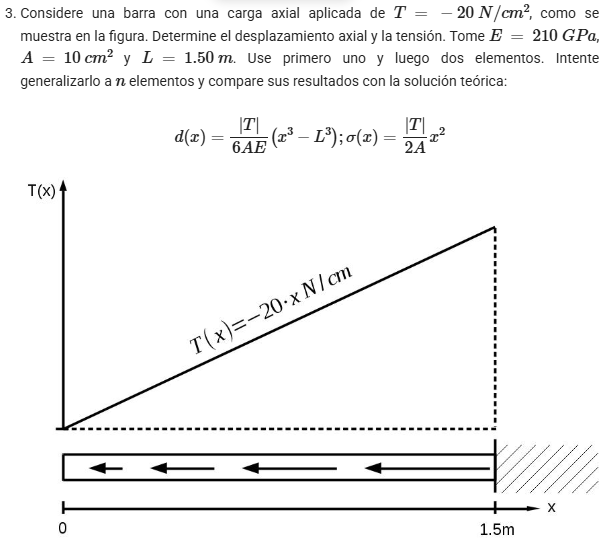

In [24]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [25]:
# Datos el problema

E = 30e6   #    [N/cm2]
L = 60     #    [cm] 
T= -10     #    [Carga distribuida N/cm]

a = 2      #    [cm2]

gl = 1     #    Es la cantidad de grados de libertad

cantDeElementos = 10


In [26]:
def vectorb(cantDeElementos,T,L):
    #   Definicion del vector de fuerzas

    F = np.zeros([cantDeElementos + 1])     # Se tiene una fuerza por cada nodo del sistema

    aux = 0

    for n in range (cantDeElementos):
        
        Faux = 1/2 * T * (L/cantDeElementos)**2

        #   Estas serian las fuerzas para cada nodo 

        aux1 = (1/3) * Faux + n * ( Faux )
        aux2 = (2/3) * Faux + n * ( Faux)

        #   Se debe sumar las fuerzas actuantes en cada nodo

        F[n] = aux1 + aux
        F[n+1] = aux2

        aux = aux2

    #.....................................................................................................

    #   Ensamblo mi vetor b para la resolucion del sistema mixto

    #   Para el problema defino la matriz de condiciones de contorno. 

    #   La primera columna me indica el tipo de dato que conozco
    #       Si es 0 se conoce la fuerza
    #       Si es 1 se conoce el desplazamiento

    b = np.zeros([cantDeElementos + 1,2])

    #   Para este problema yo conozco las fuerzas en cada nodo salvo en el ultimo donde conozco el dezplazamiento que por estar empotrado es 0

    b[0:, 1] = F[0:]

    Fend = F[-1]    # Tomo el ultimo valor del vector de fuerzas, ya que es el que me va a ayudar a calcular la reaccion

    #   Condicion de empotramiento

    b[-1, 0] = 1
    b[-1, 1] = 0

    return b , Fend

In [27]:
def MatrizMNMC(cantDeElementos,L,a):

        #............... DEFINO MI MATRIZ DE NODOS ..........................................

    MN = np.zeros(([cantDeElementos + 1 ,2]),dtype=float)

    for e in range(cantDeElementos + 1):
        aux = e * L / cantDeElementos
        MN[e,0] = aux

    #............... DEFINO MI MATRIZ DE ELEMENTOS .......................................

    MC = np.zeros(([cantDeElementos,2]),dtype=int)

    for e in range(cantDeElementos):
        MC[e, 0] = e
        MC[e, 1] = e + 1 

    #............... DEFINO MI MATRIZ DE AREAS ...........................................

    A = np.ones(MC.shape[0])*a

    #......................................................................................

    return MN , MC , A

In [28]:
def MatrizDeRigidezConSistemaMixto(MC, MN, E, A, b, glxn):

	n,m = MC.shape		# n es la cantidad de elementos que va a tener mi sistema
	r,l = MN.shape

	K = np.zeros((glxn*r,glxn*r))

	e = 0

	for e in range(n):  # Recorro los elementos del sistema

		#	Calculo el angulo tita y la longitud para cada elemento

		if glxn == 2:
			tita_e = np.arctan2( MN[ MC[e,1] , 1 ] - MN[ MC[e,0] , 1 ] , MN[ MC[e,1] , 0 ] - MN[ MC[e,0] , 0 ])

			L_e = np.sqrt( (MN[ MC[e,1] , 0 ] - MN[ MC[e,0] , 0])**2 + (MN[ MC[e,1] , 1 ] - MN[ MC[e,0] , 1 ])**2 )

			#	Calculo la constate k que acompaña a cada matriz para cada elemento 
			
			k_e = ( E * A[e] ) / L_e        #   (Se modifica para que tome el area de cada elemento)

			#	Se calcula la matriz de rotacion de cada elemento

			c = np.cos(tita_e)
			s = np.sin(tita_e)

			K_rot = k_e * np.array([[ c*c , c*s , -c*c , -c*s ],
									[ c*s , s*s , -c*s , -s*s ],
									[ -c*c , -c*s , c*c , c*s ],
									[ -c*s , -s*s , c*s , s*s ]])
			
			for i in range(glxn):

				ni = MC[e,i]

				rangoi = np.arange(i * glxn,( i + 1 ) * glxn)
				
				rangoni = np.arange(ni * glxn,( ni + 1 ) * glxn)

				for j in range(glxn):

					nj = MC[e,j]

					rangoj =  np.arange(j * glxn, (j + 1) * glxn)
					rangonj = np.arange(nj*glxn,(nj + 1) * glxn)

					K[np.ix_(rangoni,rangonj)] += K_rot[np.ix_(rangoi, rangoj)]

		
		elif glxn == 1:

			k_e = ( E * A[e] ) / ( L / MC.shape[0] )

			K_rot = k_e * np.array([[ 1 , -1 ],
						  			[ -1 , 1 ]])
			
			Ni = MC[e,0]
			Nj = MC[e,1]

			indices = np.array([ Ni * glxn , Nj * glxn])
		
			#	Esta funcion es para crear una malla de indices.

			K[np.ix_(indices,indices)] += K_rot

	#.............................................................................................................
	#.............................................................................................................

	#............................... CALCULO DE FUERZAS Y DESPLAZAMIENTOS ........................................

    #   Se define el vecctor de las fuerzas y los desplzamientos 

	l, p = np.shape(b)

	F = np.zeros([l,1])
	U = np.zeros([l,1])

	aux = b[:, 0] == 0  # Donde se conoce el valor de la fuerza
	aux2 = b[:, 0] == 1  # Donde se conoce el valor del desplazamiento

	I = np.arange(l) # Se define un vector de indices


	f_indices = I[aux]   # Índices conocidos de fuerza
	u_indices = I[aux2]  # Índices conocidos de dezplazamiento

    #   Esto asigna los valores que ya conozco a los vectores de Fuerza y Desplazamiento que quiero de mi problema

	F[aux] = b[aux,1].reshape(-1, 1) 
	U[aux2] = b[aux2,1].reshape(-1, 1)

    #   Construyo la matriz reducida

	A_red_f = K[np.ix_(f_indices,f_indices)]
    #A_red_u = A[np.ix_(u_indices,u_indices)]

	f_aux = F[f_indices]
    #u_aux = U[u_indices]

    #   Resuelvo el sistema de ecuaciones reducido

	u_sol = np.linalg.inv(A_red_f) @ (f_aux - K[np.ix_(f_indices,u_indices)] @ U[u_indices])

    #   Asigno los valores calculados a mi vector de Desplazamientos con CC

	U[f_indices] = u_sol

	F = np.dot(K,U)     # Se multiplican las matries para encontrar el vector de Fuerzas ... 

	#...............................................................................................................
	#...............................................................................................................

	#........................ CALCULO DE TENSIONES .................................................................

	Ten = np.zeros([n,1])
	
	B = np.array([-1, 1]) * ( 1 / (L/n) )		# Este es el vector B definido en TEORIA 5 Pag52 

	for e in range(n): 		#	Recorro los elementos del sistema
		Ten[e] = E * B @ U[e:e+2]
	
	return K, U, F, Ten

In [29]:
# b, Fend = vectorb(cantDeElementos,T,L)
# MN , MC , A = MatrizMNMC(cantDeElementos,L,a)
# K,U,F, Ten = MatrizDeRigidezConSistemaMixto(MC, MN, E, A, b, gl)

In [30]:
# Resultados obtenidos  

# print('Desplazamientos calculados')
# print(np.round(U,5))
# print('Fuerzas calculadas')
# print(np.round(F,5))

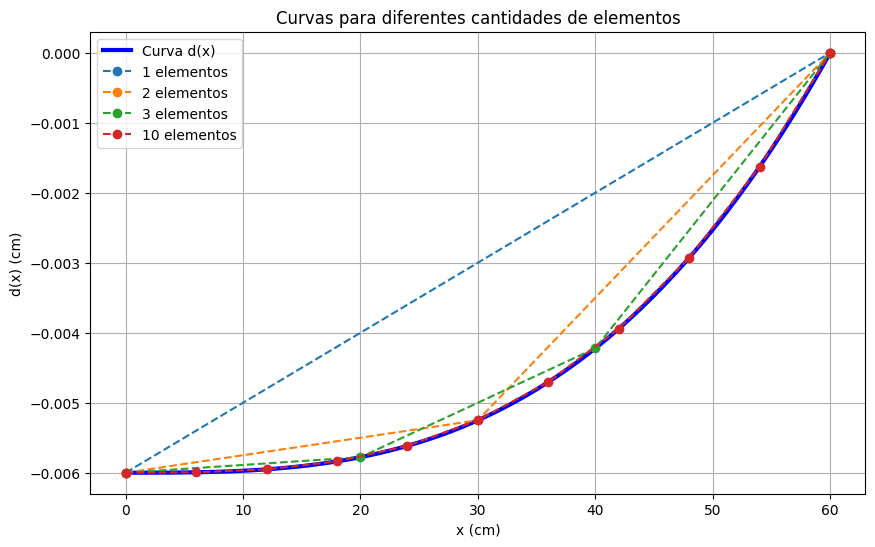

In [32]:
#   Definicion de la solucion exacta para el problema

d = lambda x: abs(T) / (6 * E * a) * ( x**3 - L**3)
xREAL = np.linspace(0, L, 200)
yREAL = d(xREAL)

# Defino la cantidad de elementos para cada sistema

elementos = [1, 2, 3, 10]

#....................................................................

#................. INICIO DEL GRAFICO ................................

plt.figure(figsize=(10, 6))

#   Curva - Solucion exacta

plt.plot(xREAL,yREAL, label='Curva d(x)', color='b', linewidth=3)

#   Curvas - Solucion calculada

for cant in elementos:

    b, Fend = vectorb(cant,T,L)
    MN, MC, A = MatrizMNMC(cant, L, a)
    K, U, F,Ten = MatrizDeRigidezConSistemaMixto(MC, MN, E, A, b, gl)
    
    X = MN[0:, 0]  #    Distancias
    Y = U          #    Desplazamientos
    
    plt.plot(X, Y, 'o--', label=f'{cant} elementos')


    #    Se calcula la reaccion de vinculo en el ultimo nodo

    #reaccion = F[-1] - Fend
    #print(reaccion)


plt.title('Curvas para diferentes cantidades de elementos')
plt.xlabel('x (cm)')
plt.ylabel('d(x) (cm)')
plt.grid(True)
plt.legend()
plt.show()

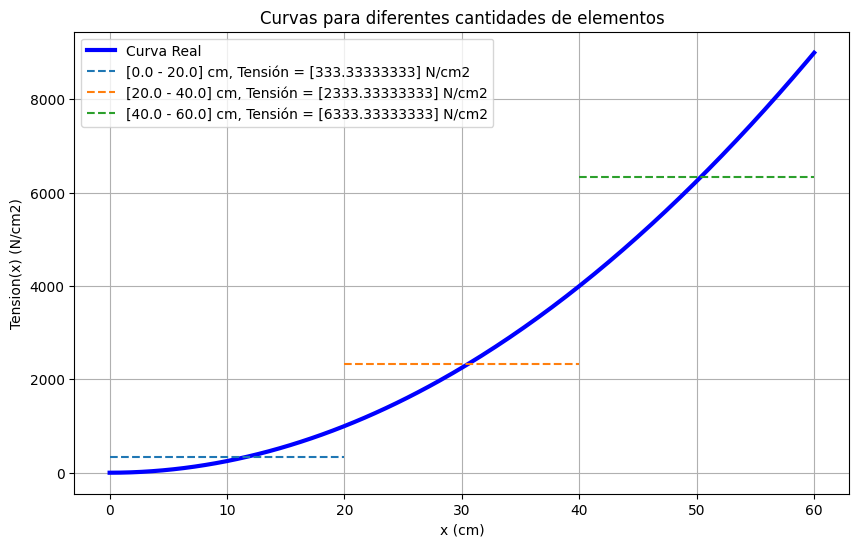

[[ 0.  0.]
 [20.  0.]
 [40.  0.]
 [60.  0.]]


In [ ]:
#   Definicion de la solucion exacta para el problema

Tension = lambda x: abs(T) / ( 2*a ) * ( x**2)
xREAL = np.linspace(0, L, 200)
yREAL = Tension(xREAL)

#....................................................................

#................. INICIO DEL GRAFICO ................................

plt.figure(figsize=(10, 6))

#   Curva - Solucion exacta

plt.plot(xREAL,yREAL, label='Curva Real', color='b', linewidth=3)

#   Curva - Solucion calculada

cantDeElementos = 3

b, Fend = vectorb(cantDeElementos,T,L)

MN, MC, A = MatrizMNMC(cantDeElementos, L, a)

K, U, F,Ten = MatrizDeRigidezConSistemaMixto(MC, MN, E, A, b, gl)

for e in range (cantDeElementos):

    X = np.linspace(MN[e, 0], MN[e+1, 0], 20)
    Y = np.full_like(X, Ten[e])                 #   Esto es para hacer constante el valor de tension-

    plt.plot(X, Y, '--', label=f'[{MN[e,0]} - {MN[e+1,0]}] cm, Tensión = {Ten[e]} N/cm2')



plt.title('Curvas para diferentes cantidades de elementos')
plt.xlabel('x (cm)')
plt.ylabel('Tension(x) (N/cm2)')
plt.grid(True)
plt.legend()
plt.show()